In [2]:
# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
# utils
import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from torchmetrics import Accuracy, Precision, Recall, F1Score

In [3]:
# global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_path = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"
image_size = (224,224)
num_classes = 4
train_paths = glob(f"{train_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.jpg")

In [4]:
# check device
device

'cuda'

In [5]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [7]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)

In [8]:
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5, random_state=ord("H"))

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

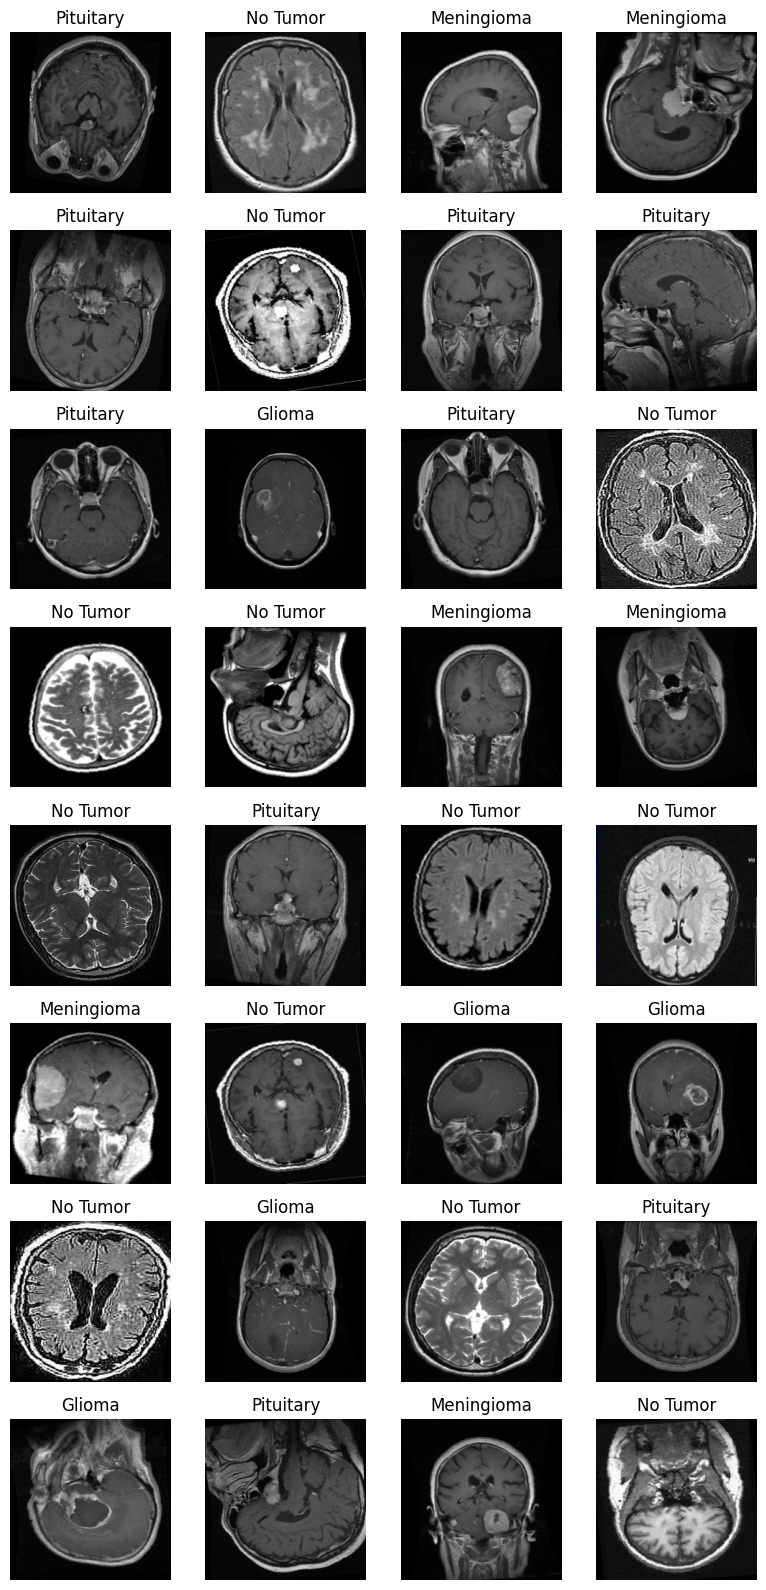

In [10]:
class AdvancedMRI_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedMRI_Classifier, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        self.fc_block = nn.Sequential(
            nn.Linear(64 * 56 * 56, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x


In [11]:
model = AdvancedMRI_Classifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [42]:


def train_epoch():
    model.train()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels_indices = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        TP = 0
        FN = 0
        outputs = model(images)
        loss = criterion(outputs, labels_indices)
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        TP += (predicted == labels_indices).sum().item()
        FN += (predicted != labels_indices).sum().item()
        total_predictions += labels_indices.size(0)
        total_correct += (predicted == labels_indices).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_number and batch_number % 150 == 0):
            c_loss = total_loss / (batch_number + 1)
            accuracy = total_correct / total_predictions
            print(f"Batch {batch_number}/{len(train_loader)}, Loss: {c_loss:0.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions
    recall = TP / (TP + FN)
    
    return avg_loss, avg_accuracy, recall


In [43]:
f1_m = []
prec_m = []
rec_m = []


def eval_model():
    
    global f1_m, prec_m, rec_m, num_classes
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    precision = Precision(task='multiclass', num_classes=num_classes).to(device)
    recall = Recall(task='multiclass', num_classes=num_classes).to(device)
    f1 =  F1Score(task='multiclass', num_classes=num_classes).to(device)
    
    with torch.no_grad():
        TP = 0
        FN = 0

        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            precision(predicted, labels_indices)
            recall(predicted, labels_indices)
            f1(predicted, labels_indices)
            TP += (predicted == labels_indices).sum().item()
            FN += (predicted != labels_indices).sum().item()

            
    precision_value = precision.compute()
    recall_value = recall.compute()
    f1_value = f1.compute()
    f1_m.append(f1_value)
    prec_m.append(precision_value)
    rec_m.append(recall_value)
    recall = TP / (TP + FN)

            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy, recall


In [44]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_rec = []
val_rec = []

In [45]:
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy, train_recall = train_epoch()
    avg_eval_loss, eval_accuracy, eval_recall = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    train_rec.append(train_recall)
    val_rec.append(eval_recall)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}, Train recall: {train_recall * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}, Eval Accuracy: {eval_recall * 100:.2f}%")
    print("#" * 70)


Epoch 0,   Batch 150/179, Loss: 0.1934, Accuracy: 92.94%
Train Loss: 0.1870, Train Accuracy: 93.15, Train recall: 100.00%
Eval Loss: 0.2183, Eval Accuracy: 91.76, Eval Accuracy: 91.76%
######################################################################
Epoch 1,   Batch 150/179, Loss: 0.1722, Accuracy: 93.52%
Train Loss: 0.1724, Train Accuracy: 93.49, Train recall: 100.00%
Eval Loss: 0.1698, Eval Accuracy: 93.74, Eval Accuracy: 93.74%
######################################################################
Epoch 2,   Batch 150/179, Loss: 0.1650, Accuracy: 94.31%
Train Loss: 0.1666, Train Accuracy: 94.21, Train recall: 87.50%
Eval Loss: 0.1963, Eval Accuracy: 93.59, Eval Accuracy: 93.59%
######################################################################
Epoch 3,   Batch 150/179, Loss: 0.1542, Accuracy: 94.85%
Train Loss: 0.1521, Train Accuracy: 94.98, Train recall: 93.75%
Eval Loss: 0.1915, Eval Accuracy: 92.98, Eval Accuracy: 92.98%
#################################################

In [56]:
val_rec

[0.917557251908397,
 0.9374045801526718,
 0.9358778625954198,
 0.9297709923664123,
 0.9419847328244275,
 0.9496183206106871,
 0.9557251908396946,
 0.9557251908396946,
 0.9496183206106871,
 0.9511450381679389]

In [57]:
f1_m

[tensor(0.9176, device='cuda:0'),
 tensor(0.9374, device='cuda:0'),
 tensor(0.9359, device='cuda:0'),
 tensor(0.9298, device='cuda:0'),
 tensor(0.9420, device='cuda:0'),
 tensor(0.9496, device='cuda:0'),
 tensor(0.9557, device='cuda:0'),
 tensor(0.9557, device='cuda:0'),
 tensor(0.9496, device='cuda:0'),
 tensor(0.9511, device='cuda:0')]

In [58]:
train_rec

[1.0, 1.0, 0.875, 0.9375, 0.875, 1.0, 1.0, 1.0, 1.0, 0.875]

In [59]:
val_accuracies

[0.917557251908397,
 0.9374045801526718,
 0.9358778625954198,
 0.9297709923664123,
 0.9419847328244275,
 0.9496183206106871,
 0.9557251908396946,
 0.9557251908396946,
 0.9496183206106871,
 0.9511450381679389]

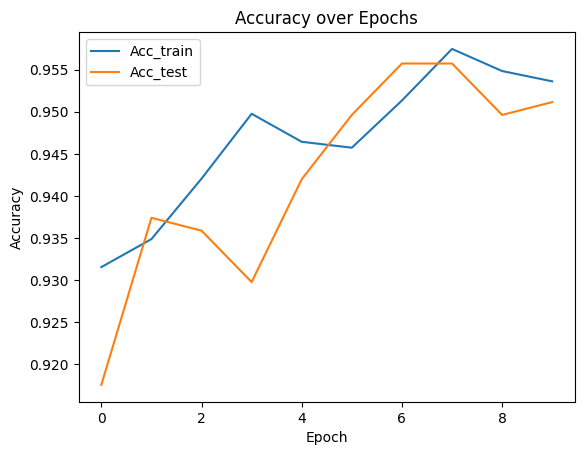

In [60]:
plt.plot(train_accuracies, label='Acc_train')
plt.plot(val_accuracies, label='Acc_test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()